In [5]:
import keras
print(keras.__version__)

2.11.0


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import LearningRateScheduler
import re
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.11.0


In [7]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

In [34]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
# PREPARE DATA FOR NEURAL NETWORK
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)
Y_test = to_categorical(Y_test, num_classes = 10)
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [11]:
nets = 15
model = [0] *nets
with strategy.scope():
    for j in range(nets):
        model[j] = Sequential()

        model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
        model[j].add(BatchNormalization())
        model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Dropout(0.4))

        model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Dropout(0.4))

        model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
        model[j].add(BatchNormalization())
        model[j].add(Flatten())
        model[j].add(Dropout(0.4))
        model[j].add(Dense(10, activation='softmax'))

        # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
        model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [12]:
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
# TRAIN NETWORKS
history = [0] * nets
epochs = 45
with strategy.scope():
    for j in range(nets):
        print('Hi')
        X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
        history[j] = model[j].fit_generator(datagen.flow(X_train2,Y_train2, batch_size=64),
                                    epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
                                    validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
        print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
            j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

Hi


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == "":
2023-03-01 14:27:08.930892: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


KeyError: 'acc'

In [13]:
with strategy.scope():
    for j in range(1,nets):
        print('Hi')
        X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
        history[j] = model[j].fit(datagen.flow(X_train2,Y_train2, batch_size=64),
                                    epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
                                    validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
        print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
            j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

Hi


2023-03-01 15:16:26.014139: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


CNN 2: Epochs=45, Train accuracy=0.99583, Validation accuracy=0.99683
Hi


2023-03-01 15:42:20.204974: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


CNN 3: Epochs=45, Train accuracy=0.99622, Validation accuracy=0.99600
Hi


2023-03-01 16:08:45.329210: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


CNN 4: Epochs=45, Train accuracy=0.99579, Validation accuracy=0.99667
Hi


2023-03-01 16:34:34.536601: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


CNN 5: Epochs=45, Train accuracy=0.99549, Validation accuracy=0.99750
Hi


2023-03-01 16:59:13.543424: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


CNN 6: Epochs=45, Train accuracy=0.99583, Validation accuracy=0.99600
Hi


2023-03-01 17:25:14.467745: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


CNN 7: Epochs=45, Train accuracy=0.99601, Validation accuracy=0.99650
Hi


2023-03-01 17:50:50.614610: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_21/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


CNN 8: Epochs=45, Train accuracy=0.99590, Validation accuracy=0.99700
Hi


2023-03-01 18:16:14.033098: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


CNN 9: Epochs=45, Train accuracy=0.99583, Validation accuracy=0.99633
Hi


2023-03-01 18:42:16.831198: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_27/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


CNN 10: Epochs=45, Train accuracy=0.99575, Validation accuracy=0.99750
Hi


2023-03-01 19:08:19.045724: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


CNN 11: Epochs=45, Train accuracy=0.99590, Validation accuracy=0.99667
Hi


2023-03-01 19:33:24.906951: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/dropout_33/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


CNN 12: Epochs=45, Train accuracy=0.99587, Validation accuracy=0.99617
Hi


2023-03-01 19:58:18.940788: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_12/dropout_36/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


CNN 13: Epochs=45, Train accuracy=0.99588, Validation accuracy=0.99717
Hi


2023-03-01 20:22:53.165083: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_13/dropout_39/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


CNN 14: Epochs=45, Train accuracy=0.99596, Validation accuracy=0.99633
Hi


2023-03-01 20:48:05.416849: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_14/dropout_42/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


CNN 15: Epochs=45, Train accuracy=0.99572, Validation accuracy=0.99583


In [14]:
with strategy.scope():
    for i in range(0,nets):
        f_name = "/kaggle/working/model{}.h5".format(i)
        model[i].save(f_name)

In [47]:
model_input = tf.keras.Input(shape=(28 ,28 ,1))
model_outputs = [m(model_input) for m in model]
output= tf.keras.layers.Add()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=output)
ensemble_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [48]:
ensemble_model.save('/kaggle/working/ensemble_model3.h5')

In [49]:
from tensorflow.keras.models import load_model

test_model = load_model('/kaggle/working/ensemble_model3.h5')

In [22]:
test_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 10)           327242      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 10)           327242      ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 10)           327242      ['input_1[0][0]']                
                                                                                              

In [44]:
score= test_model.predict(X_test)
#print("Test accuracy:", score[1])

313/313 [==============================] - 7s 16ms/step


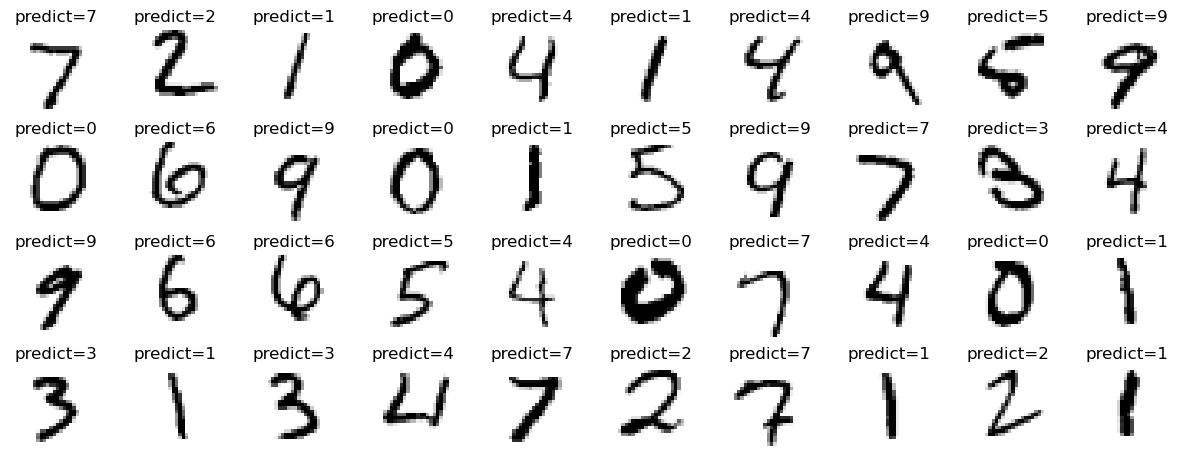

In [45]:
import matplotlib.pyplot as plt
import numpy as np
result = np.argmax(score,axis = 1)
plt.figure(figsize=(15,6))
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_test[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("predict=%d" % result[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

In [38]:
test_iterator = datagen.flow(X_test, Y_test)


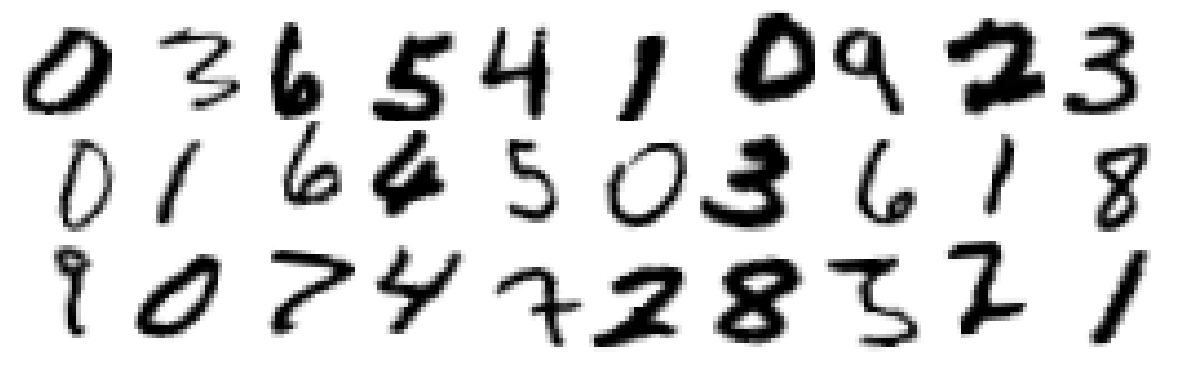

In [41]:
X_train3 = X_train[9,].reshape((1,28,28,1))
Y_train3 = Y_train[9,].reshape((1,10))
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = test_iterator.next()
    plt.imshow(X_train2[0].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
    if i==9: X_train3 = X_train[11,].reshape((1,28,28,1))
    if i==19: X_train3 = X_train[18,].reshape((1,28,28,1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [50]:
score_ensemble = test_model.evaluate(test_iterator)
print("Test accuracy:", score_ensemble[1])

313/313 [==============================] - 10s 26ms/step - loss: 0.0086 - accuracy: 0.9970
Test accuracy: 0.996999979019165
